In [2]:
semantic_hierarchy = {
                'Level-1': ['wordnet_person_100007846', 'wordnet_organization_108008335', 'wordnet_body_of_water_109225146', 
                            'wordnet_product_104007894'],
    
               'Level-2-Organizations': ['wordnet_musical_organization_108246613', 'wordnet_party_108256968', 
                                         'wordnet_enterprise_108056231', 'wordnet_nongovernmental_organization_108009834'],  
    
               'Level-2-Persons': ['wordnet_artist_109812338', 'wordnet_officeholder_110371450', 'wordnet_writer_110794014', 
                                   'wordnet_scientist_110560637', 'wordnet_politician_110450303'],         
    
               'Level-3-Artists': ['wordnet_painter_110391653', 'wordnet_sculptor_110566072', 'wordnet_photographer_110426749', 
                                   'wordnet_illustrator_109812068', 'wordnet_printmaker_110475687']           
 
               }

In [4]:
hierarchies = {}
count = 0
for level, wordnet_types in semantic_hierarchy.items():
    if level not in hierarchies:
        hierarchies[level] = []
    for wordnet_type in wordnet_types:
        if wordnet_type not in hierarchies[level]:
            count += 1
            hierarchies[level].append(wordnet_type)
            
print(f"Counts:{count}")
print("-"*100)

print(f"keys: {hierarchies.keys()}")
print("-"*100)

for key, items in hierarchies.items():
    print(key, "\t", len(items))

Counts:18
----------------------------------------------------------------------------------------------------
keys: dict_keys(['Level-1', 'Level-2-Organizations', 'Level-2-Persons', 'Level-3-Artists'])
----------------------------------------------------------------------------------------------------
Level-1 	 4
Level-2-Organizations 	 4
Level-2-Persons 	 5
Level-3-Artists 	 5


In [5]:
level1_mapper = {}

for level, wordnet_types in semantic_hierarchy.items():
    if level.startswith("Level-1"):        
        for wordnet_type in wordnet_types:
            level1_mapper[wordnet_type] = level + "@" + '_'.join(wordnet_type.split("_")[1:-1])

level1_mapper

{'wordnet_person_100007846': 'Level-1@person',
 'wordnet_organization_108008335': 'Level-1@organization',
 'wordnet_body_of_water_109225146': 'Level-1@body_of_water',
 'wordnet_product_104007894': 'Level-1@product'}

In [6]:
level2_mapper = {}

for level, wordnet_types in semantic_hierarchy.items():
    if level.startswith("Level-2"):        
        for wordnet_type in wordnet_types:
            level2_mapper[wordnet_type] = level + "@" + '_'.join(wordnet_type.split("_")[1:-1])

level2_mapper

{'wordnet_musical_organization_108246613': 'Level-2-Organizations@musical_organization',
 'wordnet_party_108256968': 'Level-2-Organizations@party',
 'wordnet_enterprise_108056231': 'Level-2-Organizations@enterprise',
 'wordnet_nongovernmental_organization_108009834': 'Level-2-Organizations@nongovernmental_organization',
 'wordnet_artist_109812338': 'Level-2-Persons@artist',
 'wordnet_officeholder_110371450': 'Level-2-Persons@officeholder',
 'wordnet_writer_110794014': 'Level-2-Persons@writer',
 'wordnet_scientist_110560637': 'Level-2-Persons@scientist',
 'wordnet_politician_110450303': 'Level-2-Persons@politician'}

In [7]:
level3_mapper = {}

for level, wordnet_types in semantic_hierarchy.items():
    if level.startswith("Level-3"):        
        for wordnet_type in wordnet_types:
            level3_mapper[wordnet_type] = level + "@" + '_'.join(wordnet_type.split("_")[1:-1])

level3_mapper

{'wordnet_painter_110391653': 'Level-3-Artists@painter',
 'wordnet_sculptor_110566072': 'Level-3-Artists@sculptor',
 'wordnet_photographer_110426749': 'Level-3-Artists@photographer',
 'wordnet_illustrator_109812068': 'Level-3-Artists@illustrator',
 'wordnet_printmaker_110475687': 'Level-3-Artists@printmaker'}

In [8]:
import json

semantic_hierarchy = {
    "level-1": level1_mapper,
    "level-2": level2_mapper,
    "level-3": level3_mapper
}

path = "assets/FreeBase/"

with open(path+"freebase_llms2ol_hierarchy.json", "w") as js_file:
    js_file.write(json.dumps(semantic_hierarchy, indent=4))

In [9]:
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
import os

config = BaseConfig().get_args(db_name="fb15k-237")

In [138]:
def add_levels(items_lst, mapper):
    mapped_levels_lst = []
    for items in items_lst:
        mapped_level = []
        if str(items) != 'nan':
            for item in eval(str(items)):
                if mapper.get(item, "NA") != "NA":
                    mapped_level.append(mapper.get(item))
        mapped_levels_lst.append(list(set(mapped_level)))
    return mapped_levels_lst

def add_levels_to_df(df, level1, level2, level3):
    df['level-1'] = add_levels(df['entclass'].tolist(), level1)
    df['level-2'] = add_levels(df['entclass'].tolist(), level2)
    df['level-3'] = add_levels(df['entclass'].tolist(), level3)
    return df


def create_level_mapper(freebase_hierarchy):
    hierarchy = DataReader.load_json(freebase_hierarchy)
    level_mappers = {"level-1":{}, "level-2":{}, "level-3":{}}
    for level, level_dict in hierarchy.items():
        for wordnet_type, level_class in level_dict.items():
            level_mappers[level][wordnet_type] = level_class
    return level_mappers['level-1'], level_mappers['level-2'], level_mappers['level-3']


################################################################################################################
def make_entity_df(df, dataset_name):
    df_ent = pd.concat([
            df[['head-mid']].rename(columns={'head-mid':"mid"}), 
            df[['tail-mid']].rename(columns={'tail-mid':"mid"})
            ]).reset_index(drop=True)
    print("-"*40)
    print(f"{dataset_name} size before removing duplicates based on [mid] is:{df_ent.shape[0]}")
    df_ent = df_ent.drop_duplicates(subset=['mid'], keep='first').reset_index()
    print(f"Current size  after droping duplicates is: {df_ent.shape[0]}")
    return df_ent

def create_mid2entclass_mapper(freebase_types_path, freebase_hierarchy):
    print("-"*40)
    type_df = DataReader.load_csv(freebase_types_path, sep='\t', names=["mid", "wordnet_type"])
    hierarchy = DataReader.load_json(freebase_hierarchy)

    wordnet_types_to_consider = []
    for _, level_dict in hierarchy.items():
        for wordnet_type, _ in level_dict.items():
            wordnet_types_to_consider.append(wordnet_type)
    wordnet_types_to_consider = list(set(wordnet_types_to_consider))    

    type_df = type_df[type_df['wordnet_type'].isin(wordnet_types_to_consider)]
    print("Shape of WordNet types dataframe is:", type_df.shape[0])
    print("Number of unique values for WordNet types are:", len(type_df['wordnet_type'].unique()))

    mid2entclass_mapper = {}
    for mid, wordnet_type in zip(type_df['mid'].tolist(), type_df['wordnet_type'].tolist()):
        if mid not in mid2entclass_mapper:
            mid2entclass_mapper[mid] = []
        mid2entclass_mapper[mid].append(wordnet_type)
    print(f"At the end size of MID2EntClass mapper is:{len(mid2entclass_mapper)}")
    return mid2entclass_mapper


def convert_mid2ent_classes(df, mid2entclass_mapper, dataset_name):
    print("-"*40)
    print(f"working on dataset in converting MID2EntClass: {dataset_name}")
    df['entclass'] = df['mid'].map(mid2entclass_mapper)
    old_size = df.shape[0]
    df = df.dropna(subset=['entclass'])
    print(f"Number of NANS in {dataset_name} set is: {old_size - df.shape[0]}")
    print(f"Current size of {dataset_name} is:{df.shape[0]}")
    return df


def convert_mid2names(df, mid2name_mapper, dataset_name):
    print("-"*40)
    print(f"working on dataset in converting MID2Names: {dataset_name}")
    df['name'] = df['mid'].map(mid2name_mapper)
    old_size = df.shape[0]
    df = df.dropna()
    print(f"Number of NANS in {dataset_name} set is: {old_size - df.shape[0]}")
    print(f"Current size of {dataset_name} is:{df.shape[0]}")
    return df

def creat_freebase_fb15kbased_mapper(dir_path):
    mid2names_dict = {}
    for js_file in os.listdir(dir_path):
        js_file_path = os.path.join(dir_path, js_file)
        fold_data = DataReader.load_json(js_file_path)
        for key, folds in fold_data.items():
            mid2names_dict_lst = []
            for fold in folds:
                try:
                    _, rel, tail = fold[2:-6].split("\\t")
                    if "type.object.name" in rel and "@en" in tail:
                        mid2names_dict_lst.append(tail.split("@")[0][1:-1])
                except:
                    continue
            if len(mid2names_dict_lst) != 0:
                mid2names_dict["/"+key.replace(".", "/")] = mid2names_dict_lst
    mid2names_dict = {key: values[0] for key, values in mid2names_dict.items()}
    return mid2names_dict

In [139]:
# load datasets
train, test, valid = DataReader.load_csv(config.raw_train, sep='\t', names=["head-mid", "relation", "tail-mid"]), \
                     DataReader.load_csv(config.raw_test, sep='\t',  names=["head-mid", "relation", "tail-mid"]), \
                     DataReader.load_csv(config.raw_valid, sep='\t', names=["head-mid", "relation", "tail-mid"])
train.head(2)

,head-mid,relation,tail-mid
0,/m/027rn,/location/country/form_of_government,/m/06cx9
1,/m/017dcd,/tv/tv_program/regular_cast./tv/regular_tv_app...,/m/06v8s0


In [140]:
train_ent, test_ent, valid_ent = make_entity_df(train, "Train"), make_entity_df(test, "Test"), make_entity_df(valid, "Valid")

train_ent.head(2)

----------------------------------------
Train size before removing duplicates based on [mid] is:544230
Current size  after droping duplicates is: 14505
----------------------------------------
Test size before removing duplicates based on [mid] is:40932
Current size  after droping duplicates is: 10348
----------------------------------------
Valid size before removing duplicates based on [mid] is:35070
Current size  after droping duplicates is: 9809


,index,mid
0,0,/m/027rn
1,1,/m/017dcd


In [141]:
mid2entclass = create_mid2entclass_mapper(config.freebase_types, config.freebase_hierarchy)

train_ent, test_ent, valid_ent = convert_mid2ent_classes(train_ent, mid2entclass, "Train"), \
                                 convert_mid2ent_classes(test_ent, mid2entclass, "Test"), \
                                 convert_mid2ent_classes(valid_ent, mid2entclass, "Valid")

train_ent.head(2)

----------------------------------------
Shape of WordNet types dataframe is: 13358
Number of unique values for WordNet types are: 18
At the end size of MID2EntClass mapper is:8423
----------------------------------------
working on dataset in converting MID2EntClass: Train
Number of NANS in Train set is: 6082
Current size of Train is:8423
----------------------------------------
working on dataset in converting MID2EntClass: Test
Number of NANS in Test set is: 3913
Current size of Test is:6435
----------------------------------------
working on dataset in converting MID2EntClass: Valid
Number of NANS in Valid set is: 3684
Current size of Valid is:6125


,index,mid,entclass
3,3,/m/01sl1q,"[wordnet_writer_110794014, wordnet_person_1000..."
5,5,/m/04nrcg,[wordnet_organization_108008335]


In [142]:
mid2name = creat_freebase_fb15kbased_mapper(dir_path=config.freebase_dumps_dir)

train_ent, test_ent, valid_ent = convert_mid2names(train_ent, mid2name, "Train"), \
                                 convert_mid2names(test_ent,  mid2name, "Test"), \
                                 convert_mid2names(valid_ent, mid2name, "Valid")
train_ent.head(2)

----------------------------------------
working on dataset in converting MID2Names: Train
Number of NANS in Train set is: 12
Current size of Train is:8411
----------------------------------------
working on dataset in converting MID2Names: Test
Number of NANS in Test set is: 9
Current size of Test is:6426
----------------------------------------
working on dataset in converting MID2Names: Valid
Number of NANS in Valid set is: 11
Current size of Valid is:6114


,index,mid,entclass,name
3,3,/m/01sl1q,"[wordnet_writer_110794014, wordnet_person_1000...",Michelle Rodriguez
5,5,/m/04nrcg,[wordnet_organization_108008335],Maldives national football team


In [143]:
wordnet2level1, wordnet2level2, wordnet2level3 = create_level_mapper(config.freebase_hierarchy)

train_ent, test_ent, valid_ent = add_levels_to_df(train_ent, wordnet2level1, wordnet2level2, wordnet2level3), \
                                 add_levels_to_df(test_ent, wordnet2level1, wordnet2level2, wordnet2level3), \
                                 add_levels_to_df(valid_ent, wordnet2level1, wordnet2level2, wordnet2level3)

train_ent.head(3)

,index,mid,entclass,name,level-1,level-2,level-3
3,3,/m/01sl1q,"[wordnet_writer_110794014, wordnet_person_1000...",Michelle Rodriguez,[Level-1@person],[Level-2-Persons@writer],[]
5,5,/m/04nrcg,[wordnet_organization_108008335],Maldives national football team,[Level-1@organization],[],[]
6,6,/m/07nznf,"[wordnet_writer_110794014, wordnet_person_1000...",Bryan Singer,[Level-1@person],[Level-2-Persons@writer],[]


In [177]:
def get_level1_based_on_level2(level):
    return level[:7].replace("2", "1@") + ''.join(level[8:].split('@')[0])

def get_level1_based_on_level3(level):
    return level[:7].replace("3", "1@") + ''.join(level[8:].split('@')[0].split("-")[0])

def get_level2_based_on_level3(level):
    return level[:7].replace("3", "2-") + '@'.join(level[8:].split('@')[0].split("-"))

def make_levels_cleaner(df):
    level1_ref, level2_ref, level3_ref = [], [], []
    for level1, level2, level3 in zip(df['level-1'], df['level-2'], df['level-3']):
        if len(level1) == 0:
            if len(level2) != 0:
                level1_based_on_level2 = []
                for level in level2:
                    level1_based_on_level2.append(get_level1_based_on_level2(level))
                level1_temp = list(set(level1_based_on_level2))
            elif len(level3) != 0:
                level1_based_on_level3 = []
                for level in level3:
                    level1_based_on_level3.append(get_level1_based_on_level3(level))
                level1_temp = list(set(level1_based_on_level2))
        else:
            level1_temp = list(set(level1))

        if len(level2) == 0 and len(level3) != 0:
            level2_based_on_level3 = []
            for level in level3:
                level2_based_on_level3.append(get_level2_based_on_level3(level))
            level2_temp = list(set(level2_based_on_level3))

        else:
            level2_temp = list(set(level2))
        level3_temp = list(set(level3))

        #‌ LEVEL 1 11111111111111111111111111111111111111111111
        if len(level1_temp) == 1:
            level1_ref.append(level1_temp[0])    
        elif len(level1_temp) == 0:
            level1_ref.append(None)
        else:
            if level2_temp == ['Level-2-event@social_event', 'Level-2-event@show']:
                level1_ref.append("Level-1@event")
            elif level2_temp == ['Level-2-event@social_event']:
                level1_ref.append("Level-1@event")

        #‌ LEVEL 2 22222222222222222222222222222222222222222222
        if len(level2_temp) == 1:
            level2_ref.append(level2_temp[0])
        elif len(level2_temp) == 0:
            level2_ref.append(None)
        else:
            level2_based_on_level3_2nd = []
            for level in level3_temp:
                level2_based_on_level3_2nd.append(get_level2_based_on_level3(level))

            level2_based_on_level3_2nd = list(set(level2_based_on_level3_2nd))
            intersection_lst = list(set(level2_based_on_level3_2nd).intersection(set(level2_temp)))

            if len(intersection_lst) == 1:
                level2_temp = intersection_lst.copy()
                new_level3_temp = []
                for level in level3_temp:
                    if get_level2_based_on_level3(level) in intersection_lst:
                        new_level3_temp.append(level)

                level3_temp = list(set(new_level3_temp)).copy()
                level2_ref.append(level2_temp[0])

            else:
                if len(intersection_lst) == 0:
                    level3_temp = []
                    level2_ref.append(level2_temp[0])
                else:
                    level2_temp = intersection_lst[:1].copy()
                    new_level3_temp = []
                    for level in level3_temp:
                        if get_level2_based_on_level3(level) in level2_temp:
                            new_level3_temp.append(level)
                    level2_ref.append(level2_temp[0])
                    level3_temp = new_level3_temp.copy()

                    # for l in new_level3_temp:
                    #     if "Level-3" in l:
                    #         print(l)
        #‌ LEVEL 3 3333333333333333333333333333333333333333333333333333
        if len(level3_temp) == 1:
            level3_ref.append(level3_temp[0])
        elif len(level3_temp) == 0:
            level3_ref.append(None)
        else:
            # for l in level3_temp:
            #     level3_temp_fq_dict[l] += 1
            level3_ref.append(level3_temp[0])
            # print("level3_temp:", level3_temp)
            # print("-"*70)
            # level3_ref.append(level3_temp)
    print(df.shape[0], "l1:", len(level1_ref), "l2:", len(level2_ref), "l3:", len(level3_ref) )
    df['level-1-cleaned'] = level1_ref
    df['level-2-cleaned'] = level2_ref
    df['level-3-cleaned'] = level3_ref
    return df

In [178]:
train_en_clear = make_levels_cleaner(train_ent)
test_en_clear = make_levels_cleaner(test_ent)
valid_en_clear = make_levels_cleaner(valid_ent)

df_ent = pd.concat([train_en_clear, test_en_clear, valid_en_clear]).reset_index(drop=True)
df_ent = df_ent.drop_duplicates(subset=['mid', 'name'], keep='first').reset_index()

print("shape of dataframe is:", df_ent.shape[0])

df_ent.head(5)

8411 l1: 8411 l2: 8411 l3: 8411
6426 l1: 6426 l2: 6426 l3: 6426
6114 l1: 6114 l2: 6114 l3: 6114
shape of dataframe is: 8411


,level_0,index,mid,entclass,name,level-1,level-2,level-3,level-1-cleaned,level-2-cleaned,level-3-cleaned
0,0,3,/m/01sl1q,"[wordnet_writer_110794014, wordnet_person_1000...",Michelle Rodriguez,[Level-1@person],[Level-2-Persons@writer],[],Level-1@person,Level-2-Persons@writer,None
1,1,5,/m/04nrcg,[wordnet_organization_108008335],Maldives national football team,[Level-1@organization],[],[],Level-1@organization,None,None
2,2,6,/m/07nznf,"[wordnet_writer_110794014, wordnet_person_1000...",Bryan Singer,[Level-1@person],[Level-2-Persons@writer],[],Level-1@person,Level-2-Persons@writer,None
3,3,8,/m/0q9kd,[wordnet_person_100007846],Danny DeVito,[Level-1@person],[],[],Level-1@person,None,None
4,4,11,/m/0b76d_m,[wordnet_product_104007894],Anonymous,[Level-1@product],[],[],Level-1@product,None,None


Text(0.5, 1.0, 'TRAIN-VALID Level-3 Frequencies')

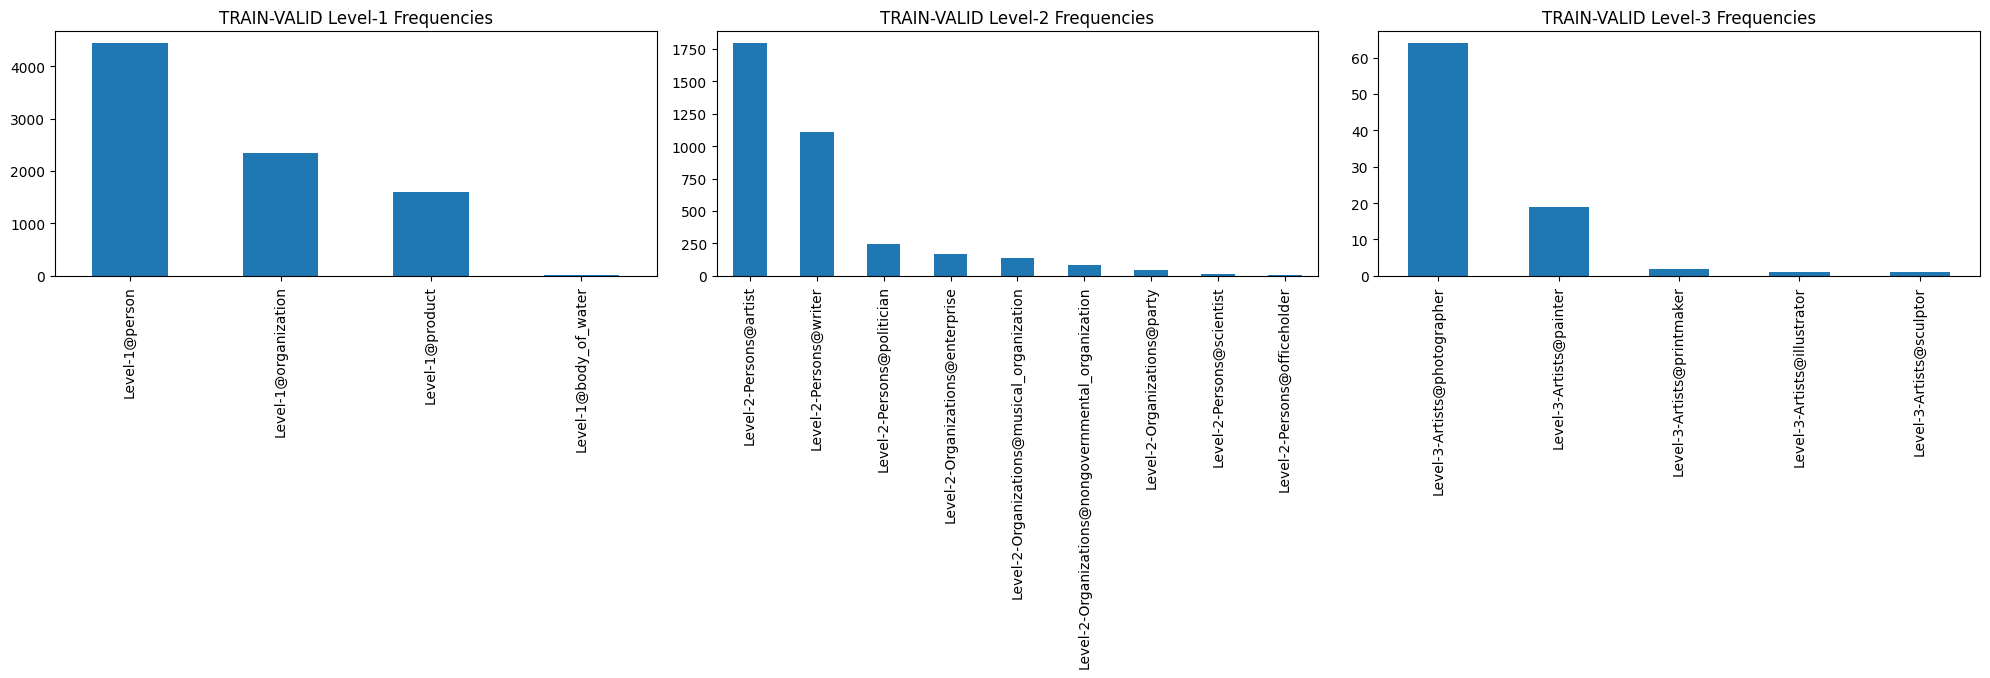

In [179]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,16))
plt.rcParams["figure.autolayout"] = True

ax1 = fig.add_subplot(3, 9, (1, 3))
df_ent['level-1-cleaned'].value_counts().plot(ax=ax1, kind='bar')
ax1.set_title('TRAIN-VALID Level-1 Frequencies')

ax2 = fig.add_subplot(3, 9, (4, 6))
df_ent['level-2-cleaned'].value_counts().plot(ax=ax2, kind='bar')
ax2.set_title('TRAIN-VALID Level-2 Frequencies')

ax4 = fig.add_subplot(3, 9, (7, 9))
df_ent['level-3-cleaned'].value_counts().plot(ax=ax4, kind='bar', legend=False)
ax4.set_title('TRAIN-VALID Level-3 Frequencies')

In [180]:
df_ent['level-1-cleaned'].value_counts()

Level-1@person           4443
Level-1@organization     2353
Level-1@product          1591
Level-1@body_of_water      24
Name: level-1-cleaned, dtype: int64

In [183]:
sum(df_ent['level-1-cleaned'].value_counts()), sum(df_ent['level-2-cleaned'].value_counts()), sum(df_ent['level-3-cleaned'].value_counts())

(8411, 3597, 87)

In [182]:
df_ent['level-2-cleaned'].value_counts()

Level-2-Persons@artist                                1795
Level-2-Persons@writer                                1112
Level-2-Persons@politician                             245
Level-2-Organizations@enterprise                       169
Level-2-Organizations@musical_organization             136
Level-2-Organizations@nongovernmental_organization      80
Level-2-Organizations@party                             42
Level-2-Persons@scientist                               10
Level-2-Persons@officeholder                             8
Name: level-2-cleaned, dtype: int64

In [175]:
df_ent['level-3-cleaned'].value_counts()

Level-3-Artists@photographer    64
Level-3-Artists@painter         19
Level-3-Artists@printmaker       2
Level-3-Artists@illustrator      1
Level-3-Artists@sculptor         1
Name: level-3-cleaned, dtype: int64

In [186]:
# Level 1
from collections import defaultdict

level_items = defaultdict(int)

for items in df_ent['level-1']:
    for item in items:
        level_items[item] += 1
level_items

defaultdict(int,
            {'Level-1@person': 4443,
             'Level-1@organization': 2353,
             'Level-1@product': 1591,
             'Level-1@body_of_water': 24})

In [187]:
# Level 1
from collections import defaultdict

level_items = defaultdict(int)

for items in df_ent['level-2']:
    for item in items:
        level_items[item] += 1
level_items

defaultdict(int,
            {'Level-2-Persons@writer': 1917,
             'Level-2-Persons@artist': 1891,
             'Level-2-Persons@politician': 245,
             'Level-2-Organizations@enterprise': 169,
             'Level-2-Persons@scientist': 115,
             'Level-2-Persons@officeholder': 108,
             'Level-2-Organizations@nongovernmental_organization': 82,
             'Level-2-Organizations@party': 42,
             'Level-2-Organizations@musical_organization': 137})

In [189]:
115+108+245+1891+1917

4276

In [188]:
# Level 1
from collections import defaultdict

level_items = defaultdict(int)

for items in df_ent['level-3']:
    for item in items:
        level_items[item] += 1
level_items

defaultdict(int,
            {'Level-3-Artists@photographer': 110,
             'Level-3-Artists@painter': 69,
             'Level-3-Artists@illustrator': 20,
             'Level-3-Artists@sculptor': 15,
             'Level-3-Artists@printmaker': 11})